# Classificação de texto com avaliações de filmes

Este estudo classifica avaliações de filmes como **positivas** ou **negativas** somente com o texto de avaliação. Isso é um exemplo de classificação *binária*, um importante e muito utilizado tipo de problema de aprendizado de máquina.

Para o estudo, usaremos a base de dados [IMDB](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb?hl=pt-br) o qual possui avaliações de mais de 50 mil filmes da base de dados [Internet Movie Database](https://www.imdb.com/). A base é dividida em 25 mil avaliações para treino e 25 mil avaliações para teste. Os conjuntos são balanceados, isto é: possuem a mesma quantidade de avaliações positivas e negativas.

O estudo usa [tf.keras](https://www.tensorflow.org/guide/keras?hl=pt-br), uma API alto-nível para construir e treinar modelos com o TensorFlow.

## Importar as bibliotecas

In [1]:
# Importar o TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras

# Importar a biblioteca auxiliar
import numpy as np

In [2]:
# Saber a versão do TensorFlow
print(tf.__version__)

2.8.2


## Baixar a base de dados IMDB

A base de dados já vem com o TensorFlow. Os dados já são pré-processados para que as avaliações (sequências de palavras) sejam transformadas em sequências de inteiros, onde cada inteiro representa uma palavra específica do dicionário.

O código abaixo baixa os dados para o nosso estudo:

In [3]:
# Baixar os dados
imdb = keras.datasets.imdb
(dados_treino, rotulos_treino), (dados_teste, rotulos_teste) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


O argumento `num_words=10000` possui as 10 mil palavras mais frequentes no conjunto de treino. As palavras mais raras são descartadas para preservar o tamanho dos dados de forma maleável.

## Explorar os dados

Vejamos como é o formato dos dados. O conjunto de dados vem pré-processado:  cada exemplo é um array de inteiros que representa as palavras da avaliação. Cada rótulo é um inteiro com valore de 0 ou 1, onde 0 é uma avaliação negativa e 1, uma avaliação positiva.

In [4]:
# Ver o tamanho dos dados de treino
print(f'''Conjunto de treinamento:
  Dados de entrada: {len(dados_treino)}
  Rótulos: {len(rotulos_treino)}''')

Conjunto de treinamento:
  Dados de entrada: 25000
  Rótulos: 25000


O texto de avaliação foi convertido para inteiros, onde cada número representa uma palavra específica no dicionário:

In [5]:
# Ver como os dados estão dispostos
print(dados_treino[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


As avaliações dos filmes possuem tamanhos distintos. O código abaixo mostra o número de palavras da primeira e segunda avaliação. Sabendo que o número de entradas da rede neural deve ter o mesmo tamanho, é necessário que resolvamos isso mais tarde:

In [6]:
print(f'''Quantidade de palavras da 1ª entrada: {len(dados_treino[0])}
Quantidade de palavras da 2ª entrada: {len(dados_treino[1])}''')

Quantidade de palavras da 1ª entrada: 218
Quantidade de palavras da 2ª entrada: 189


### Converter os inteiros de volta a palavras

É muito útil converter os números em palavras que conheçamos. Criaremos uma função capaz de realizar essa conversão:

In [7]:
# Um dicionário para mapear as palavras a partir dos inteiros como índice
indice_palavra = imdb.get_word_index()

# Os primeiros índices são reservados
indice_palavra = {c: (v+3) for c, v in indice_palavra.items()}
indice_palavra['<PAD>'] = 0
indice_palavra['<START>'] = 1
indice_palavra['<UNK>'] = 2  # desconhecido
indice_palavra['<UNUSED>'] = 3

# O que era chave vira valor e o que era valor vira chave
inverter = dict([(v, c) for (c, v) in indice_palavra.items()])

# Criar a função de decodificação
def decodificar(texto):
  return ' '.join([inverter.get(i, '?') for i in texto])

1654784/1641221 [==============================] - 0s 0us/step


Podemos agora usar a função `decodificar()` para mostrar o texto da primeira avaliação:

In [8]:
# Decodificar a primeira avaliação
decodificar(dados_treino[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Preparar os dados

As avaliações (arrays de inteiros) necessitam ser convertidas em tensores (*tensors*) antes de entregar à rede neural. Essa conversão pode ser resolvida de duas formas:

1. Converter os arrays em vetores de 0s e 1s indicando a ocorrência da palavra, parecido com o *one-hot encoding*. Um exemplo: a sequência [3, 5] tornaria-se um vetor de 10 mil dimensões, onde todos seriam 0s, tirando 3 e 5 que seriam 1s. Depois, faremos a primeira camada da rede neural (a camada Dense) que pode trabalhar com dados em ponto flutuante. Essa abordagem é intensa em relação à memória, uma vez que necessite de uma matriz com tamanho de `quantidade_palavras * quantidade_avaliacoes`.

2. De modo alternativo, podemos preencher o array para que todos tenham o mesmo tamanho e depois criar um tensor inteiro no formato `max_comprimento * numero_avaliacoes`. Podemos usar uma camada *embedding* que seja capaz de lidar com o formato como a primeira camada da nossa rede.

Nesse estudo, usaremos a segunda maneira.

Uma vez que as avaliações dos filmes devem ter o mesmo tamanho, usaremos a função [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences?hl=pt-br) para padronizar os tamanhos:

In [9]:
# Padronizar os dados de treino
dados_treino = keras.preprocessing.sequence.pad_sequences(dados_treino,
                                                          value=indice_palavra['<PAD>'],
                                                          padding='post',
                                                          maxlen=256)

# Padronizar os dados de teste
dados_teste = keras.preprocessing.sequence.pad_sequences(dados_teste,
                                                         value=indice_palavra['<PAD>'],
                                                         padding='post',
                                                         maxlen=256)

Vejamos o tamanho das duas primeiras entradas:

In [10]:
# Analisar o tamanho das entradas
print(f'''Tamanho da primeira entrada:{len(dados_treino[0])}
Tamanho da segunda entrada: {len(dados_treino[1])}''')

Tamanho da primeira entrada:256
Tamanho da segunda entrada: 256


Vejamos também como está a primeira avaliação (agora preenchidos):

In [11]:
# Matriz com os inteiros
print(dados_treino[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Construindo o modelo

A rede neural é desenvolvida por camadas empilhadas. Para isso, precisamos saber quantas camadas serão usadas no modelo e quantas *hidden units* serão usadas em cada camada.

Neste estudo, os dados de entrada são um array de palavras-índice. Os rótulos para a previsão são 0 e 1:

In [12]:
# O formato de entrada é a contagem do vocabulário usado pelas avaliações dos filmes (10 mil palavras)
tamanho_vocabulario = 10**4

# Montar o modelo
modelo = keras .Sequential()
modelo.add(keras.layers.Embedding(tamanho_vocabulario, 16))
modelo.add(keras.layers.GlobalAveragePooling1D())
modelo.add(keras.layers.Dense(16, activation='relu'))
modelo.add(keras.layers.Dense(1, activation='sigmoid'))

# Resumo do modelo
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


As camadas são empilhadas sequencialmente para construir o classificador:

1. A primeira camada é uma camada `Embedding`. Essa camada recebe o vocabulário em inteiros e observa o vetor *embedding* em cada palavra-índice. Esses vetores são aprendidos pelo modelo durante o treino. Os vetores somam a dimensão ao array de saída. As dimensões resultantes são (`batch`, `sequence` e `embedding`).

2. Uma camada `GlobalAveragePooling1D` retorna um vetor de saída com comprimento fixo para cada exemplo, criando a média da sequência da dimensão. Isso permite o modelo trabalhar com entradas de tamanhos distintos da maneira mais simples possível.

3. Esse vetor de saída com tamanho fixo passa por uma camada *fully-connected* (`Dense`) com 16 * hidden units*.

4. A última camada é uma *densely connected* com um neurônio de saída. Usando a função `sigmoid` para ativação, esse valor é um *float* que varia de 0 a 1, representando a probabilidade, ou nível de confiança.

### Hidden units

O modelo criado possui duas camadas intermediárias ou *hidden*, entre a entrada e saída. O número de saídas (*units* ou neurônios) é a dimensão do espaço representacional para a camada. Em outras palavras, isso determina a quantidade permitida de liberdade que a rede usa enquanto está aprendendo.

Se o modelo possui mais *hidden units* e/ou mais camadas, logo a rede pode aprender padrões mais complexos. Todavia, isso faz com que a rede exija mais do computador e pode levar ao aprendizado de padrões não desejados (pode gerar um *overfit*).

### Função Loss e otimizadores (optimizer)

O modelo necessita de uma função *loss* e um otimizador (*optimizer*) para o treino. Uma vez que o problema é de classificação binária e o modelo tem como saída uma probabilidade, usaremos a função loss `binary_crossentropy`.

Há outras escolhas para a função loss, como a `mean_squared_error`, porém, a `binary_crossentropy` é ótima em tratar probabilidades, ela mede a "distância" entre as distribições das probabilidades, que no nosso caso é sobre a distribuição real e as previsões.

Vejamos como configurar o modelo para utilizar a função loss e o otimizador:

In [13]:
# Configurar a função loss e o otimizador
modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

## Criar um modelo de validação

Ao treinarmos a rede, queremos verificar a acurácia do modelo com os dados que ele nunca analisou. Criaremos um conjunto de *validação* retirando 10 mil exemplos do conjunto de treino original. Faremos isso para melhorar o nosso modelo (tunar) com os dados de treino para assim, entregar os dados de teste somente uma vez:

In [14]:
# Separar os dados de treino
x_val = dados_treino[:10000]
x_treino_parcial = dados_treino[10000:]
y_val = rotulos_treino[:10000]
y_rotulos_parcial = rotulos_treino[10000:]

## Treinar o modelo

Treinaremos o modelo em 40 *epochs* com *mini-batches* de 512 exemplos. Ao longo do treino, será mostrado os valores de loss e da acurácia do modelo nos 10 mil exemplo do conjunto de validação:

In [15]:
# Treinar o modelo
historia = modelo.fit(x_treino_parcial,
                      y_rotulos_parcial,
                      epochs=40,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 30ms/step - loss: 0.6922 - accuracy: 0.5559 - val_loss: 0.6904 - val_accuracy: 0.5909
Epoch 2/40
30/30 [==============================] - 1s 26ms/step - loss: 0.6866 - accuracy: 0.6763 - val_loss: 0.6819 - val_accuracy: 0.7284
Epoch 3/40
30/30 [==============================] - 1s 23ms/step - loss: 0.6735 - accuracy: 0.7495 - val_loss: 0.6647 - val_accuracy: 0.7499
Epoch 4/40
30/30 [==============================] - 1s 21ms/step - loss: 0.6489 - accuracy: 0.7712 - val_loss: 0.6361 - val_accuracy: 0.7560
Epoch 5/40
30/30 [==============================] - 1s 22ms/step - loss: 0.6124 - accuracy: 0.7864 - val_loss: 0.5978 - val_accuracy: 0.7879
Epoch 6/40
30/30 [==============================] - 1s 21ms/step - loss: 0.5664 - accuracy: 0.8141 - val_loss: 0.5536 - val_accuracy: 0.8089
Epoch 7/40
30/30 [==============================] - 1s 21ms/step - loss: 0.5166 - accuracy: 0.8333 - val_loss: 0.5093 - val_accuracy: 0.8234
Epoch 8/40
30

## Avaliar o modelo

Agora vejamos como o nosso modelo se saiu. Dois valores são retornados: **loss** (número que mostra o erro, quanto mais baixo, melhor) e a **acurácia**:

In [16]:
# Avaliação do modelo
resultados = modelo.evaluate(dados_teste, rotulos_teste, verbose=2)
print(resultados)

782/782 - 1s - loss: 0.3374 - accuracy: 0.8702 - 1s/epoch - 2ms/step
[0.33737534284591675, 0.8701599836349487]


Já é um bom começo, mas é possível melhorar ainda mais o modelo, chegando até 95% de acurácia.

## Criar um gráfico de acurácia e loss por tempo

O método `modelo.fit()` retorna um objeto `Historia` que possui um dicionário de tudo o que ocorreu durante o treino:

In [17]:
# Obter as chaves dos dicionários
dic_historia = historia.history
dic_historia.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

O dicionário possui 4 chaves, uma para cada métrica de validação e treinamento. Podemos utilizá-las para plotar em um gráfico a comparação do loss de treinamento e validação, bem como a acurácia do treino e validação:

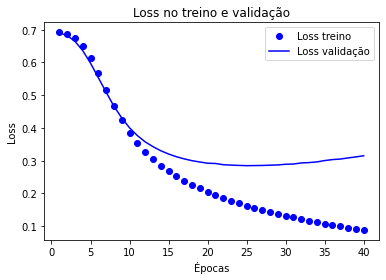

In [19]:
# Importar a biblioteca
import matplotlib.pyplot as plt

# Variáveis
acuracia = dic_historia['accuracy']
val_acuracia = dic_historia['val_accuracy']
loss = dic_historia['loss']
val_loss = dic_historia['val_loss']
epocas = range(1, len(acuracia)+1)

# Montar a plotagem
plt.plot(epocas, loss, 'bo', label='Loss treino')  # 'bo' para bolinhas azuis
plt.plot(epocas, val_loss, 'b', label='Loss validação')  # 'b' para linha azul
plt.title('Loss no treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Mostrar a plotagem
plt.show()

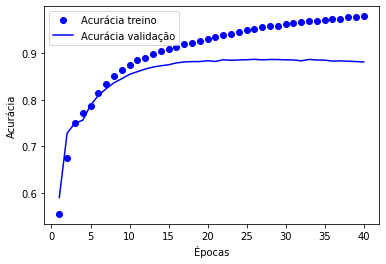

In [20]:
plt.clf()  # Limpar a plotagem anterior

# Montar a plotagem
plt.plot(epocas, acuracia, 'bo', label='Acurácia treino')  # 'bo' para bolinhas azuis
plt.plot(epocas, val_acuracia, 'b', label='Acurácia validação')  # 'b' para linha azul
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Mostrar o gráfico
plt.show()

O que vemos acima é um caso de *overfitting*. Isso ocorre quando o modelo possui um melhor desempenho com os dados de treino do que com os dados que ele nunca viu, ou seja, ele não generaliza bem.

Para esse estudo, poderiamos ter parado perto de 20 epochs para evitar o *overfitting*. Veremos nos próximos estudos como podemos fazer isso de modo automático com um *callback*.